# Optimizing Deep Q Learning with SHAP Explanations
Exploring Minimum Experience Replay Buffer Sizes for Reinforcement Learning

### Installation Instructions
* Windows 10 was used.
* VS Code was used may ask to install ipykernal package to run notebook
* Install Python 3.8. Visit: https://www.python.org/downloads/release/python-380/
* Python Virtual environment. c:\Python38\python -m venv c:\path\to\venv_research Visit: https://docs.python.org/3/library/venv.html
* PyTorch on Windows only supports Python 3.7-3.9; Python 2.x is not supported. CUDA is required: For more info visit: https://pytorch.org/get-started/locally/
* pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
* pip install matplotlib
* Install Open-Ai's Gym which is now maintained by Gymnasium, e.g import gymnasium as gym. Visit: https://gymnasium.farama.org/environments/classic_control/
* pip install gymnasium[classic-control]
* pip install box2d (swig may fail if pip install gymnasium[box2d])
* pip install gymnasium[box2d]
* pip install numpy==1.23.5 (needed for a shap dependency)
* pip install shap
* Install custom third party addiction simulator ensure hrl_gym folder available. Go to hrl_gym where setup.py is located and run pip install -e .

## Import Libraries

In [1]:
#basic
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

#pytorch for gpu processing of ML model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

#hide pytorch warnings (should eventually be resolved)
import warnings
warnings.filterwarnings("ignore")

#Simulations
import hrl_gym #simulate addiction
import gymnasium as gym

#!pip install shap
#github.com/slundberg/shap, 
#https://www.youtube.com/watch?v=Ty7qf3mV_Qc, 
#https://github.com/dynamik1703/gym_longicontrol/blob/master/Jupyter/LongiControl_SHAP.ipynb
# https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16

from sklearn.model_selection import train_test_split #for splitting memory into training and testing

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from statsmodels.formula.api import ols

import shap 
shap.initjs() #call for each plot

## Deep Q-Learning Agent

### Neural Network Model
Q value function approximator

In [2]:
class Network(nn.Module):  
    def __init__(self, input_size, nb_action):
        #ref: https://discuss.pytorch.org/t/super-model-in-init/97426
        #super(Network, self).__init__()
        super().__init__() #pytorch's NN model
        self.input_size = input_size
        self.nb_action = nb_action
        self.fc1 = nn.Linear(input_size, 30)#arbitrarily chose 30 hidden layers
        self.fc2 = nn.Linear(30, nb_action)
    
    #base pytorch NN model runs and we override the
    #forward function with our own relu activation function
    def forward(self, state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

### Experience Replay Model
This model is used for training our DQN model. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [3]:
class ReplayMemory(): 
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0] #forget first transition
    
    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size)) 
        return map(lambda x: Variable(torch.cat(x, 0)), samples) #tensor and gradient.
        #this contains sample of memory. get random sample from memory with given size
        # before list = [[state,action,reward], [state,action,reward]] zip*=> [[state], [action], [reward]]
        #the * operator unpacks a list and applies it to a function
        #a pytorch variable contains a tensor and a gradient. in order for pytorch to differenciate with respect to a tensor, we need a tensor and gradient
        # For each batch within a sample, we then have to concatenate it to the first dimension because 
        # everything needs to be aligned so state action and reward align to same time t
        # Lambda is used to do a short computation inline without def and if, etc.
        

### Agent (DQN Learning System )
Comprised of a neural network model and a memory model. 
* The NN takes in observation of sensor data (brain chemicals) and chooses actions based on the relu activation function. 
* The agent will sample some of the sensor data and store in long term memory to be reused later for training. 
* We also use the Adam Optimisation algorithm. This is an extension to stocastic gradient desent to update weights of the neural network. 

In [4]:
class Dqn():
    def __init__(self, input_size, nb_action, gamma, capacity=100000, learning=0.001, temperature=100, sample_rate=100):
        self.gamma = gamma
        self.reward_window = []
        self.cumulative_rewards = []
        self.model = Network(input_size, nb_action)
        self.memory = ReplayMemory(capacity) #100k
        self.sample_rate = sample_rate
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning)
        self.last_state = torch.Tensor(input_size).unsqueeze(0)
        self.last_action = 0
        self.last_reward = 0
        self.temp = temperature
        self.explainer = None #used to calculate shap values
        self.shap_values = [] #store collected shap values

        #create table for memory data collection
        self.df = pd.DataFrame(columns=['batch_state', 'batch_next_state', 'batch_action', 'batch_reward'])

    # select action for x duration
    def select_action(self, state):
        #softmax converts numbers into probabilities
        #Q values are the output of the neural network
            #view q values
        q_value_tensor = self.model(Variable(state, volatile = True)) 
        q_values = [q_value.detach().numpy() for q_value in q_value_tensor]
            #print(q_values)
            #viz q value for each action, (T value by user choice)
            #pie chart 0/1 #seperate action
        # Temperature value = 100. closer to zero the less sure the NN will be to taking the action
        probs = F.softmax(self.model(Variable(state, volatile = True))*self.temp) # T=100
        
        action_prob = [prob.detach().numpy() for prob in probs]

        action = probs.multinomial(num_samples=1) # action taken
        #q_values[0][action] #quality of taking action in state
        #action_prob[0][action] #probability of taking action

        #return the action taken, q values and probabilities of taking action given state.
        #return action.data[0,0], q_values[0][action], action_prob[0][action]
        return action.data[0,0], q_values, action_prob
    
    #When ai reaches a new state we update everything
    #update action, last action becomes the new action but also the last state becomes the new state and last reward becomes the new state
    # we then get this new transition and update our reward window to track training progress and exploration
    def update(self, reward, new_signal):
        new_state = torch.Tensor(new_signal).float().unsqueeze(0)
        self.memory.push((self.last_state, new_state, torch.LongTensor([int(self.last_action)]), torch.Tensor([self.last_reward])))
        action, q, p = self.select_action(new_state)
        if len(self.memory.memory) > self.sample_rate: #100
            batch_state, batch_next_state, batch_action, batch_reward = self.memory.sample(self.sample_rate)

            #first converting tensors to numpy arrays
            batch_state_np = batch_state.numpy()
            batch_next_state_np = batch_next_state.numpy()
            batch_action_np = batch_action.numpy()
            batch_reward_np = batch_reward.numpy()

            # Split the data into training and testing sets
            state_train, state_test, next_state_train, next_state_test, action_train, action_test, reward_train, reward_test = train_test_split(
                batch_state_np, batch_next_state_np, batch_action_np, batch_reward_np, test_size=0.1, random_state=42)
            
            # Convert back to tensors
            state_train = torch.tensor(state_train)
            next_state_train = torch.tensor(next_state_train)
            reward_train = torch.tensor(reward_train)
            action_train = torch.tensor(action_train)
            state_test = torch.tensor(state_test)
            next_state_test = torch.tensor(next_state_test)
            reward_test = torch.tensor(reward_test)
            action_test = torch.tensor(action_test)

            self.df.loc[len(self.df)] = [state_test, next_state_test, reward_test, action_test]

            self.learn(state_train, next_state_train, reward_train, action_train)
            #self.learn(batch_state, batch_next_state, batch_reward, batch_action)
            #X=batch_state and y=batch_next_state
        self.last_action = action
        self.last_state = new_state
        self.last_reward = reward
        self.reward_window.append(reward)
        self.cumulative_rewards.append(sum(self.reward_window))
        #if len(self.reward_window) > 1000:
        #    del self.reward_window[0]
        return action, q, p
    
    #to train our AI
    #forward propagation then backproagation
    # get our output, target, compare our output to the target to compute the loss error
    # backproagate loss error into the nn and use stochastic gradient descent we update the weights according to how much they contributed to the loss error
    def learn(self, batch_state, batch_next_state, batch_reward, batch_action):
        #when we pass in batch state the output will be all possible actions
        # we use gather passing in 1 and batch action because we only want the chosen action
        # however batch_state has a fake dimention from unsqueeze in __init__ of NN and batch action doesn't
        outputs = self.model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1) #pass state into neural network input layer., gather outputs a new tensor. input dimension
        #gets the q values for all the next states with respect to action (i.e 1) then get the max
        next_outputs = self.model(batch_next_state).detach().max(1)[0]
        target = self.gamma*next_outputs + batch_reward
        td_loss = F.smooth_l1_loss(outputs, target)
        self.optimizer.zero_grad()
        td_loss.backward(retain_graph = True)
        self.optimizer.step()
    
    def score(self):
        #return sum(self.reward_window)/(len(self.reward_window)+1.0)
        return sum(self.reward_window)
    
    def cumulative_reward(self):
        #return sum(self.reward_window)/(len(self.reward_window)+1.0)
        return self.cumulative_rewards
    
    def rewards(self):
        #return sum(self.reward_window)/(len(self.reward_window)+1.0)
        return self.reward_window
    
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')
    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")

In [5]:
#create table for evaluating capacity against reward
df_rewards = pd.DataFrame(columns=['capacity', 'episodes', 'reward'])

## Lunar Lander Simulator Experiment
A classic rocket trajectory optimization problem, simulating landing on the moon with a Lunar lander.
According to Pontryagin's maximum principle, it is optimal to fire the engine at full throttle 
or turn it off. This is the reason why this environment has discrete actions: engine on or off.

<u>Observation Space</u>

The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear
velocities in `x` & `y`, its angle, its angular velocity, and two booleans
that represent whether each leg is in contact with the ground or not.

<u>Action Space</u>

There are four discrete actions available: do nothing, fire left
orientation engine, fire main engine, fire right orientation engine.

<u>Rewards</u>

After every step a reward is granted. The total reward of an episode is the
sum of the rewards for all the steps within that episode.
For each step, the reward:
- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.
The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
An episode is considered a solution if it scores at least 200 points.

<u> Starting State</u>

The lander starts at the top center of the viewport with a random initial
force applied to its center of mass.

<u>Episode Termination</u>

The episode finishes if:
1) the lander crashes (the lander body gets in contact with the moon);
2) the lander gets outside of the viewport (`x` coordinate is greater than 1);
3) the lander is not awake. From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61),
    a body which is not awake is a body which doesn't move and doesn't
    collide with any other body:

* When Box2D determines that a body (or group of bodies) has come to rest, the body enters a sleep state which has very little CPU overhead. 
* If a body is awake and collides with a sleeping body, then the sleeping body wakes up. 
* Bodies will also wake up if a joint or contact attached to them is destroyed.

### 1,000,000 Capacity Size

In [6]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [7]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 1000000 #memory capacity
m = 128 #memory sampling (100 samples and ~10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [8]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-1.0147682   3.4321628  -2.049575    1.64551     0.5417931   0.14923672
  0.          0.        ], action: 2, score: -591.3480319651924


episode: 1, obs: [ 1.0064669   2.4180095   1.8089678   0.14625855 -1.5323632  -1.3511407
  0.          0.        ], action: 3, score: -488.1257954386701
episode: 2, obs: [-0.63491476 -0.04805667 -0.53474176  0.12680005  1.694276   -0.01106184
  0.          1.        ], action: 3, score: -243.21944970760362
episode: 3, obs: [ 6.4679340e-02 -4.2790629e-02 -4.2470099e-08 -7.5791229e-15
  2.2916000e-04  1.9219786e-07  1.0000000e+00  1.0000000e+00], action: 0, score: -119.60188654778568
episode: 4, obs: [ 0.10890675 -0.04046086  0.05153446 -1.1261307  -0.02610957  6.4742355
  1.          1.        ], action: 0, score: -115.42614847081839
episode: 5, obs: [ 0.5664501  -0.09478053  0.93998194 -0.88192356 -0.54159415  5.49833
  1.          0.        ], action: 0, score: -191.89066566543949
episode: 6, obs: [-8.0025867e-02 -4.2810120e-02 -8.8000096e-09  2.6399297e-08
  2.5470948e-04  3.9916756e-08  1.0000000e+00  1.0000000e+00], action: 0, score: -107.51145132173019
episode: 7, obs: [ 1.0216693

#### HOW did the agent performed?

##### Agent's final score

In [9]:
#Current sum of all values in the reward window
print(agent.score())

-674213.739799185


##### Rewards at given time/step

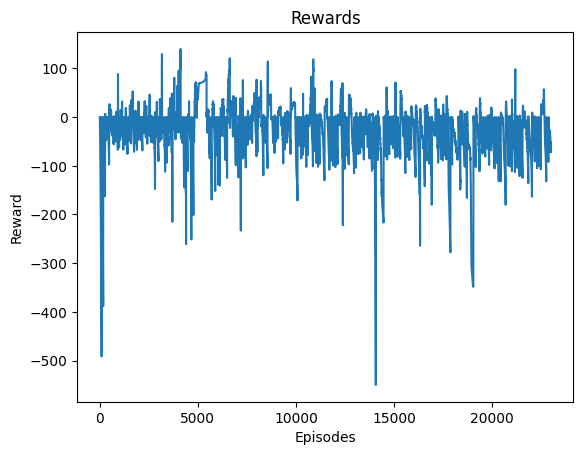

In [10]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["1M", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

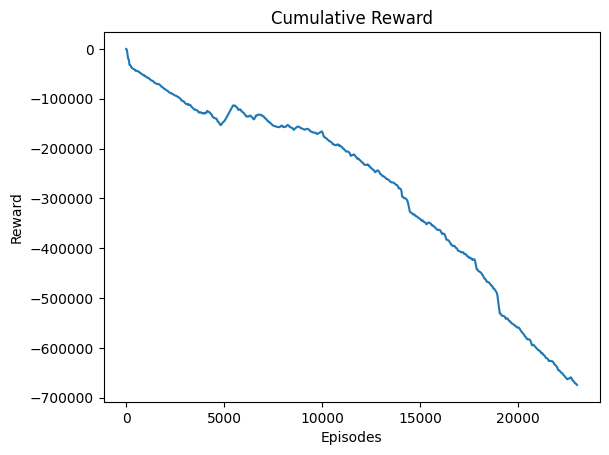

In [11]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [12]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

22861

In [13]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(0.0608), tensor(1.4352), tensor(0.783...  \
1  [[tensor(-0.5951), tensor(2.5907), tensor(-1.3...   
2  [[tensor(-0.4220), tensor(2.2127), tensor(-1.0...   
3  [[tensor(-0.7249), tensor(2.8689), tensor(-1.5...   
4  [[tensor(-0.6792), tensor(2.7716), tensor(-1.4...   

                                    batch_next_state   
0  [[tensor(0.0687), tensor(1.4403), tensor(0.801...  \
1  [[tensor(-0.6087), tensor(2.6200), tensor(-1.3...   
2  [[tensor(-0.4332), tensor(2.2377), tensor(-1.1...   
3  [[tensor(-0.7409), tensor(2.9022), tensor(-1.6...   
4  [[tensor(-0.6941), tensor(2.8035), tensor(-1.4...   

                                        batch_action   
0  [tensor(-15.0813), tensor(-407.0210), tensor(-...  \
1  [tensor(-308.5195), tensor(-66.0789), tensor(-...   
2  [tensor(-222.8073), tensor(-295.3282), tensor(...   
3  [tensor(-374.7307), tensor(-249.4267), tensor(...   
4  [tensor(-349.9747), tensor(-150.2646), tensor(...   

                                        batch_reward  
0  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
1  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
2  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
3  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
4  [tensor(2), tensor(2), tensor(2), tensor(2), t...

In [14]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[ 0.0608,  1.4352,  0.7836,  0.1995, -0.0639, -0.1535,  0.0000,  0.0000],
               [-0.7909,  3.0043, -1.6963,  1.5103,  0.4519,  0.1373,  0.0000,  0.0000],
               [-0.0687,  1.4809, -0.6124,  0.3743,  0.0692,  0.0989,  0.0000,  0.0000],
               [-0.7574,  2.9362, -1.6585,  1.5098,  0.4376,  0.1369,  0.0000,  0.0000],
               [-0.1463,  1.6148, -0.7018,  0.5717,  0.1277,  0.0844,  0.0000,  0.0000],
               [ 0.0530,  1.4307,  0.7827,  0.1854, -0.0563, -0.1510,  0.0000,  0.0000],
               [-0.2144,  1.7495, -0.7975,  0.7143,  0.1612,  0.0714,  0.0000,  0.0000],
               [-0.3515,  2.0552, -0.9440,  0.9396,  0.2447,  0.1151,  0.0000,  0.0000],
               [-0.9357,  3.2861, -1.9127,  1.5913,  0.5106,  0.1471,  0.0000,  0.0000],
               [ 0.0150,  1.4148,  0.7634,  0.0960, -0.0166, -0.1588,  0.0000,  0.0000],
               [-0.5047,  2.3945, -1.2319,  1.1866,  0.3158,  0.0960,  0.0000,  0.0000],
               [-0.00

In [15]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [16]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[ 6.0796e-02,  1.4352e+00,  7.8356e-01,  ..., -1.5349e-01,
          0.0000e+00,  0.0000e+00],
        [-7.9092e-01,  3.0043e+00, -1.6963e+00,  ...,  1.3725e-01,
          0.0000e+00,  0.0000e+00],
        [-6.8657e-02,  1.4809e+00, -6.1236e-01,  ...,  9.8943e-02,
          0.0000e+00,  0.0000e+00],
        ...,
        [-4.9009e-01,  4.5128e-01, -9.6667e-01,  ...,  1.4613e-01,
          0.0000e+00,  0.0000e+00],
        [-5.3001e-01,  1.5399e-01, -6.0007e-01,  ...,  8.8996e-02,
          0.0000e+00,  0.0000e+00],
        [ 1.1796e-01,  1.1335e+00,  1.4820e-01,  ..., -5.6132e-04,
          0.0000e+00,  0.0000e+00]])


297193

In [17]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-1.7533e-01,  1.6715e+00, -7.5844e-01,  6.4966e-01,  1.4423e-01,
          6.5719e-02,  0.0000e+00,  0.0000e+00],
        [-2.8923e-01,  1.3191e+00, -6.3580e-01, -6.9006e-01,  3.2728e-01,
          1.4189e-01,  0.0000e+00,  0.0000e+00],
        [-7.4687e-02,  1.4900e+00, -6.0846e-01,  4.0410e-01,  7.4587e-02,
          1.0859e-01,  0.0000e+00,  0.0000e+00],
        [ 1.6509e-01,  1.5256e+00,  8.1781e-01,  3.8033e-01, -1.7217e-01,
         -2.0323e-01,  0.0000e+00,  0.0000e+00],
        [-5.3537e-01,  3.4937e-01, -7.4390e-01, -1.6765e+00,  1.1456e+00,
          5.7744e-01,  0.0000e+00,  0.0000e+00],
        [ 5.0712e-01,  2.0175e+00,  1.5460e+00,  9.6022e-01, -5.3986e-01,
         -2.2970e-01,  0.0000e+00,  0.0000e+00],
        [-1.3830e-01,  1.5255e+00, -6.3601e-01, -4.9007e-02,  1.5660e-01,
          1.4199e-01,  0.0000e+00,  0.0000e+00],
        [ 3.8124e-01,  1.8317e+00,  1.2249e+00,  8.0345e-01, -4.3166e-01,
         -2.4294e-01,  0.0000e+00,  0.0000e+00],
        [-6.3628

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [18]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [19]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [20]:
shap_values

[array([[ 8.12718277e+01,  7.47743225e+00,  1.37722884e+26,
         -8.20260167e-01, -9.75100348e+18,  1.81707592e+01,
         -5.84616591e+22, -7.85095017e-06],
        [ 8.41276474e+01,  3.28445282e+01,  1.37722884e+26,
         -2.30966827e+02, -9.75100348e+18,  1.33288488e+01,
         -5.84616591e+22, -7.85095017e-06],
        [ 7.87487106e+01,  2.05443134e+01,  1.37722884e+26,
         -4.30044174e+01, -9.75100348e+18,  1.54452915e+01,
         -5.84616591e+22, -7.85095017e-06],
        [ 7.27369690e+01,  1.79787178e+01,  1.37722884e+26,
         -4.70877838e+01, -9.75100348e+18,  3.52673912e+01,
         -5.84616591e+22, -7.85095017e-06],
        [ 9.02989273e+01,  1.02665390e+02,  1.37722884e+26,
         -4.00428619e+02, -9.75100348e+18, -1.43577986e+01,
         -5.84616591e+22, -7.85095017e-06],
        [ 6.41616516e+01, -1.74324703e+01,  1.37722884e+26,
          5.25297432e+01, -9.75100348e+18,  3.69498558e+01,
         -5.84616591e+22, -7.85095017e-06],
        [ 8.0343

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

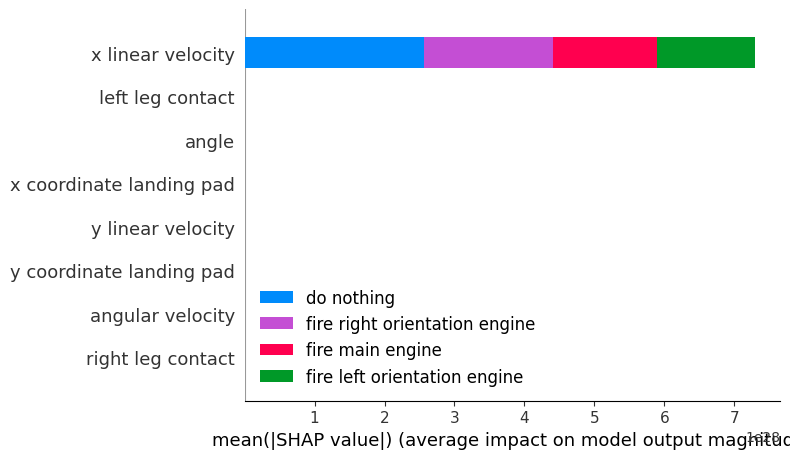

In [21]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [22]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 500,000 Capacity Size

In [23]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [24]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 500000 #memory capacity
m = 128 #memory sampling (100 samples and ~10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [25]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-0.5404295   0.0261974  -1.6895256  -0.86361426  4.7115874   6.390457
  1.          0.        ], action: 2, score: -664.4108473812433
episode: 1, obs: [-0.4599313   0.10533594 -1.399534   -0.27816924  4.425275    4.3831034
  1.          0.        ], action: 2, score: -670.705531746936
episode: 2, obs: [-0.61264956  0.02683047 -0.7687945   0.14121673  2.1089058   2.0479207
  0.          1.        ], action: 0, score: -271.665215659048
episode: 3, obs: [ 0.9858721  -0.15484904  0.46701065 -0.22661018  0.07691278  4.3275757
  0.          1.        ], action: 1, score: -198.2455858938585
episode: 4, obs: [-5.3862952e-02 -4.2780939e-02 -6.6504402e-10  1.8880774e-08
  2.5193105e-04  3.0095222e-09  1.0000000e+00  1.0000000e+00], action: 0, score: -123.04252508431225
episode: 5, obs: [-4.8229884e-02 -4.2776324e-02  3.3386259e-05  2.1001323e-08
  2.4728308e-04 -2.1575252e-07  1.0000000e+00  1.0000000e+00], action: 0, score: -103.53795172421613
episode: 6, obs: [ 1.3324241e-01 

#### HOW did the agent performed?

##### Agent's final score

In [26]:
#Current sum of all values in the reward window
print(agent.score())

-457689.35652012855


##### Rewards at given time/step

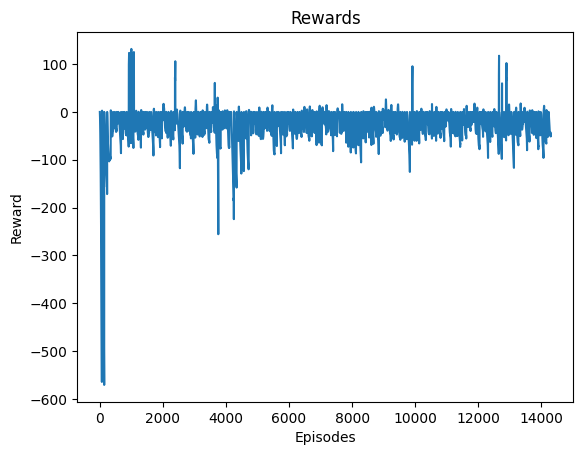

In [27]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["500k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

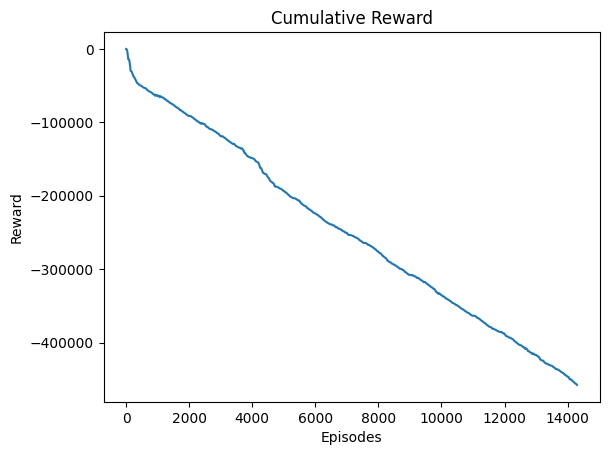

In [28]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [29]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

14171

In [30]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.0978), tensor(1.3957), tensor(-0.3...  \
1  [[tensor(-0.0716), tensor(1.4172), tensor(-0.6...   
2  [[tensor(-0.2980), tensor(0.8705), tensor(-1.1...   
3  [[tensor(-0.0046), tensor(1.4527), tensor(-0.1...   
4  [[tensor(2.2603e-42), tensor(0.), tensor(1.488...   

                                    batch_next_state   
0  [[tensor(-0.1026), tensor(1.3822), tensor(-0.4...  \
1  [[tensor(-0.0781), tensor(1.4138), tensor(-0.6...   
2  [[tensor(-0.3104), tensor(0.8272), tensor(-1.1...   
3  [[tensor(-0.0059), tensor(1.4616), tensor(-0.1...   
4  [[tensor(-0.0055), tensor(1.4147), tensor(-0.5...   

                                        batch_action   
0  [tensor(-175.3129), tensor(-453.9562), tensor(...  \
1  [tensor(-30.8741), tensor(-440.0399), tensor(-...   
2  [tensor(-440.0399), tensor(-45.4920), tensor(-...   
3  [tensor(2.3197), tensor(-58.1800), tensor(-461...   
4  [tensor(0.), tensor(-426.8106), tensor(-537.99...   

                                        batch_reward  
0  [tensor(2), tensor(2), tensor(1), tensor(2), t...  
1  [tensor(1), tensor(2), tensor(1), tensor(1), t...  
2  [tensor(2), tensor(1), tensor(1), tensor(2), t...  
3  [tensor(1), tensor(1), tensor(2), tensor(1), t...  
4  [tensor(0), tensor(2), tensor(2), tensor(1), t...

In [31]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[-0.0978,  1.3957, -0.3934, -0.6197,  1.5458,  1.6102,  0.0000,  0.0000],
               [-0.4590,  0.5376, -0.9374, -1.9721,  3.6055,  2.0326,  0.0000,  0.0000],
               [-0.0588,  1.4981, -0.3540, -0.2637,  0.7881,  1.1137,  0.0000,  0.0000],
               [-0.2256,  1.0863, -1.0906, -1.3450,  2.7178,  1.5288,  0.0000,  0.0000],
               [-0.2825,  1.0777, -0.8211, -1.0050,  1.8989,  1.8244,  0.0000,  0.0000],
               [-0.1918,  1.1707, -1.0234, -1.1650,  2.4876,  1.5526,  0.0000,  0.0000],
               [-0.3082,  1.0094, -0.8055, -1.1017,  2.1873,  1.9629,  0.0000,  0.0000],
               [-0.5036,  0.2902, -0.7320, -2.2717,  4.1098,  2.0177,  0.0000,  0.0000],
               [-0.1138,  1.3535, -0.5694, -0.7031,  1.7860,  1.6089,  0.0000,  0.0000],
               [-0.0344,  1.4249, -0.6075,  0.0360,  0.0686,  0.3221,  0.0000,  0.0000],
               [-0.0197,  1.5115, -0.2245,  0.1800,  0.1707,  0.5031,  0.0000,  0.0000],
               [-0.19

In [32]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [33]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.0978,  1.3957, -0.3934,  ...,  1.6102,  0.0000,  0.0000],
        [-0.4590,  0.5376, -0.9374,  ...,  2.0326,  0.0000,  0.0000],
        [-0.0588,  1.4981, -0.3540,  ...,  1.1137,  0.0000,  0.0000],
        ...,
        [-0.1056,  1.1157, -0.2065,  ...,  0.1356,  0.0000,  0.0000],
        [ 0.0232,  1.4269,  0.7723,  ..., -0.1005,  0.0000,  0.0000],
        [-0.2622,  1.1701, -0.7799,  ...,  0.1740,  0.0000,  0.0000]])


184223

In [34]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-0.1474,  1.3452, -0.7727, -0.4529,  0.6601,  1.0414,  0.0000,  0.0000],
        [-0.3578,  1.0599, -0.6256, -1.0075,  1.0087,  0.2008,  0.0000,  0.0000],
        [-0.0333,  1.5231, -0.2795,  0.0093,  0.3634,  0.7337,  0.0000,  0.0000],
        [-0.0308,  1.5227, -0.2711,  0.0377,  0.3267,  0.6980,  0.0000,  0.0000],
        [-0.3819,  0.8103, -1.0048, -1.4291,  2.8885,  2.0621,  0.0000,  0.0000],
        [-0.1709,  1.2200, -0.9097, -1.0438,  2.3329,  1.5418,  0.0000,  0.0000],
        [ 0.2973,  1.5749,  0.9275,  0.0645, -0.3518, -0.2024,  0.0000,  0.0000],
        [ 0.3616,  1.5686,  0.9275, -0.1222, -0.4226, -0.2024,  0.0000,  0.0000],
        [-0.4016,  0.4190, -0.9627, -2.4641,  3.8378,  1.4695,  0.0000,  0.0000],
        [-0.0496,  1.5123, -0.3303, -0.1693,  0.6275,  0.9746,  0.0000,  0.0000],
        [-0.2910,  1.0557, -0.8163, -1.0387,  1.9929,  1.8798,  0.0000,  0.0000],
        [-0.1187,  1.3802, -0.7366, -0.3300,  0.4661,  0.8583,  0.0000,  0.0000],
        [ 0.0078

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [35]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [36]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [37]:
shap_values

[array([[ 7.02950716e-01, -1.04083652e+01, -5.88581462e+25,
          8.53942795e+01, -2.44046732e+30,  7.96326828e+00,
         -2.96352127e+26, -7.84727140e-44],
        [-5.62101603e+00, -8.33421171e-01, -5.88581462e+25,
         -7.42043915e+01, -2.44046732e+30,  7.56200943e+01,
         -2.96352127e+26, -7.84727140e-44],
        [ 4.13349247e+00, -1.63775826e+01, -5.88581462e+25,
          2.18390579e+02, -2.44046732e+30,  3.27316437e+01,
         -2.96352127e+26, -7.84727140e-44],
        [ 4.20701122e+00, -1.63642750e+01, -5.88581462e+25,
          2.26571060e+02, -2.44046732e+30,  3.55998840e+01,
         -2.96352127e+26, -7.84727140e-44],
        [-6.34331894e+00,  7.53988171e+00, -5.88581462e+25,
         -1.95555740e+02, -2.44046732e+30, -7.41794815e+01,
         -2.96352127e+26, -7.84727140e-44],
        [-2.27706903e-03, -6.20775080e+00, -5.88581462e+25,
         -8.46684265e+01, -2.44046732e+30, -3.23102341e+01,
         -2.96352127e+26, -7.84727140e-44],
        [ 1.4067

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

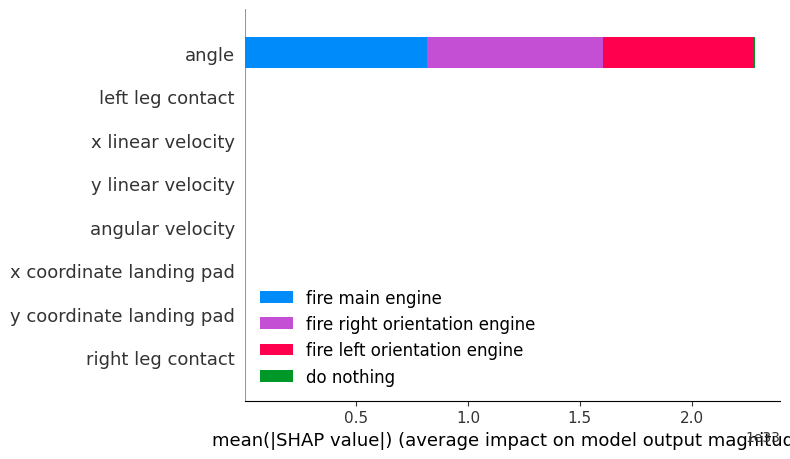

In [38]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [39]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 100,000 Capacity Size

In [40]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [41]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 100000 #memory capacity
m = 128 #memory sampling (100 samples and ~10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [42]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-0.4186986   0.05779775 -1.2135193  -0.3600898   0.40245947 -0.38216934
  0.          1.        ], action: 3, score: -154.88091897401597
episode: 1, obs: [-1.017731    3.2450836  -1.7740387   1.0418097   0.23575105 -0.6286582
  0.          0.        ], action: 3, score: -480.8522927728012
episode: 2, obs: [-0.15535536 -0.02946599  0.02089686 -0.8531741   0.15443571 -6.2016425
  0.          1.        ], action: 2, score: -148.78641489796883
episode: 3, obs: [-0.02885609 -0.04252402 -0.09910943  0.0219468   0.00375976  0.11633968
  1.          1.        ], action: 3, score: -38.126765891093854
episode: 4, obs: [ 0.31296644 -0.11761039  0.8094956  -0.44803512 -0.4475046   0.9236787
  1.          1.        ], action: 0, score: -93.45464855976039
episode: 5, obs: [ 1.0001335   0.23375617  1.7208169  -1.0106443  -0.78261775 -0.13944878
  0.          0.        ], action: 0, score: -275.4450850628328
episode: 6, obs: [ 0.6765505   0.1161167   0.28094116 -0.5399686  -0.9191724

#### HOW did the agent performed?

##### Agent's final score

In [43]:
#Current sum of all values in the reward window
print(agent.score())

-2383223.1097014793


##### Rewards at given time/step

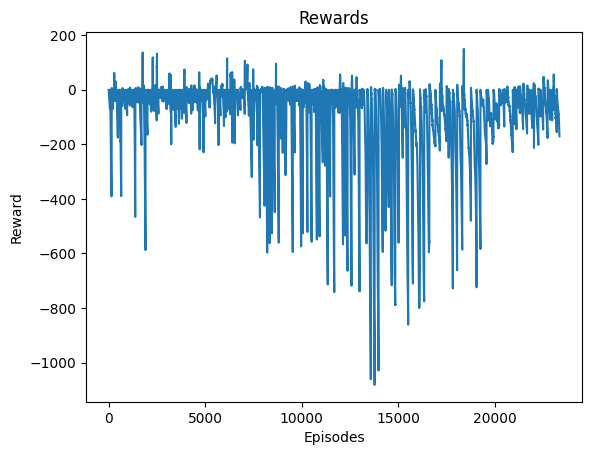

In [44]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["100k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row


# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

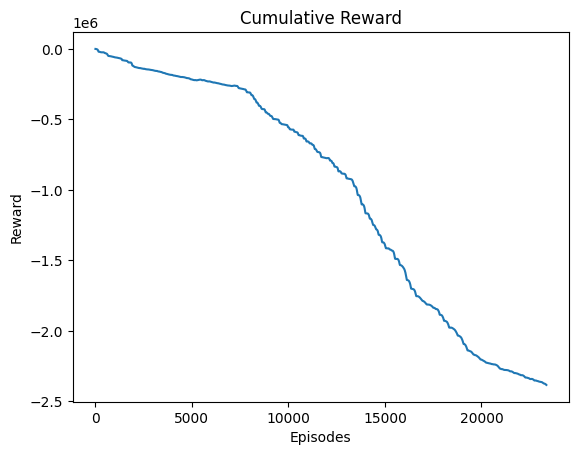

In [45]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [46]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

23240

In [47]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.2375), tensor(1.0348), tensor(-0.5...  \
1  [[tensor(-0.2264), tensor(1.0769), tensor(-0.5...   
2  [[tensor(-0.1933), tensor(1.1888), tensor(-0.5...   
3  [[tensor(-0.1822), tensor(1.2213), tensor(-0.5...   
4  [[tensor(-0.0828), tensor(1.4057), tensor(-0.5...   

                                    batch_next_state   
0  [[tensor(-0.2430), tensor(1.0129), tensor(-0.5...  \
1  [[tensor(-0.2319), tensor(1.0561), tensor(-0.5...   
2  [[tensor(-0.1988), tensor(1.1716), tensor(-0.5...   
3  [[tensor(-0.1878), tensor(1.2054), tensor(-0.5...   
4  [[tensor(-0.0883), tensor(1.4006), tensor(-0.5...   

                                        batch_action   
0  [tensor(-42.6519), tensor(-21.4626), tensor(-2...  \
1  [tensor(-40.7165), tensor(-129.3270), tensor(-...   
2  [tensor(-34.1800), tensor(-17.5282), tensor(-2...   
3  [tensor(-31.7839), tensor(-0.8229), tensor(-10...   
4  [tensor(-9.0511), tensor(-300.0173), tensor(-5...   

                                        batch_reward  
0  [tensor(0), tensor(0), tensor(2), tensor(2), t...  
1  [tensor(0), tensor(2), tensor(0), tensor(2), t...  
2  [tensor(0), tensor(0), tensor(2), tensor(0), t...  
3  [tensor(0), tensor(0), tensor(2), tensor(2), t...  
4  [tensor(0), tensor(2), tensor(0), tensor(2), t...

In [48]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[-0.2375,  1.0348, -0.5585, -0.9499,  0.2684,  0.1246,  0.0000,  0.0000],
               [-0.1381,  1.3274, -0.5587, -0.4689,  0.1563,  0.1247,  0.0000,  0.0000],
               [-0.4083,  2.2484, -1.3266,  1.1079,  0.4082,  0.0998,  0.0000,  0.0000],
               [-0.2098,  1.8346, -0.8225,  0.8772,  0.2699,  0.1908,  0.0000,  0.0000],
               [-0.1939,  1.7957, -0.7811,  0.8389,  0.2502,  0.1958,  0.0000,  0.0000],
               [-0.2761,  0.8686, -0.5585, -1.1366,  0.3121,  0.1246,  0.0000,  0.0000],
               [-0.0718,  1.4142, -0.5585, -0.1489,  0.0814,  0.1249,  0.0000,  0.0000],
               [-0.2817,  0.8424, -0.5585, -1.1633,  0.3183,  0.1246,  0.0000,  0.0000],
               [-0.0970,  1.5717, -0.6245,  0.5723,  0.1213,  0.1786,  0.0000,  0.0000],
               [-0.2623,  1.9568, -0.9573,  0.9252,  0.3248,  0.1539,  0.0000,  0.0000],
               [-0.1096,  1.5980, -0.6510,  0.5946,  0.1386,  0.1669,  0.0000,  0.0000],
               [-0.30

In [49]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [50]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.2375,  1.0348, -0.5585,  ...,  0.1246,  0.0000,  0.0000],
        [-0.1381,  1.3274, -0.5587,  ...,  0.1247,  0.0000,  0.0000],
        [-0.4083,  2.2484, -1.3266,  ...,  0.0998,  0.0000,  0.0000],
        ...,
        [ 0.0650,  2.2841, -0.5549,  ...,  1.6054,  0.0000,  0.0000],
        [ 0.0992,  1.2937,  0.8154,  ..., -0.1304,  0.0000,  0.0000],
        [-0.1915,  0.9121, -0.3075,  ...,  0.0686,  0.0000,  0.0000]])


302120

In [51]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-1.0257e-01,  8.7334e-01, -2.1879e-01, -1.1420e+00,  2.5135e-01,
          1.6480e-01,  0.0000e+00,  0.0000e+00],
        [-1.0961e-01,  1.5980e+00, -6.5096e-01,  5.9461e-01,  1.3864e-01,
          1.6690e-01,  0.0000e+00,  0.0000e+00],
        [-1.0679e-01,  8.2022e-01, -2.1879e-01, -1.1954e+00,  2.6783e-01,
          1.6480e-01,  0.0000e+00,  0.0000e+00],
        [-1.2508e-01,  5.8320e-01, -2.5380e-01, -1.4148e+00,  3.7170e-01,
          3.1214e-01,  0.0000e+00,  0.0000e+00],
        [-3.5595e-02,  1.4029e+00, -1.9645e-01, -2.5930e-01,  4.4891e-02,
          7.3946e-02,  0.0000e+00,  0.0000e+00],
        [-2.1800e-01,  1.8543e+00, -8.2986e-01,  8.7651e-01,  2.7964e-01,
          1.9401e-01,  0.0000e+00,  0.0000e+00],
        [-9.2199e-02,  9.9563e-01, -2.0864e-01, -1.0072e+00,  2.1435e-01,
          1.2278e-01,  0.0000e+00,  0.0000e+00],
        [-1.3177e-01,  4.8465e-01, -2.2485e-01, -1.4873e+00,  4.0494e-01,
          1.8330e-01,  0.0000e+00,  0.0000e+00],
        [-5.4258

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [52]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [53]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [54]:
shap_values

[array([[-2.44294701e+01, -4.34884313e+13,  1.62608200e+02,
         -1.82993027e+02,  1.47466159e+14, -1.23617754e+01,
         -1.32760513e-11, -1.01222956e+00],
        [-2.20612240e+01, -4.34884313e+13,  4.82972145e+01,
          1.90050247e+02,  1.47466159e+14, -1.27710772e+01,
         -1.32760513e-11, -1.01222956e+00],
        [-2.30124149e+01, -4.34884313e+13,  1.62609634e+02,
         -1.94452118e+02,  1.47466159e+14, -1.23614798e+01,
         -1.32760513e-11, -1.01222956e+00],
        [-1.68612366e+01, -4.34884313e+13,  1.53347275e+02,
         -2.41594818e+02,  1.47466159e+14, -4.11059837e+01,
         -1.32760513e-11, -1.01222956e+00],
        [-4.69497604e+01, -4.34884313e+13,  1.68516739e+02,
          6.62216949e+00,  1.47466159e+14,  5.36414719e+00,
         -1.32760513e-11, -1.01222956e+00],
        [ 1.43835640e+01, -4.34884313e+13,  9.74690735e-01,
          2.50605331e+02,  1.47466159e+14, -1.80589428e+01,
         -1.32760513e-11, -1.01222956e+00],
        [-2.7916

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

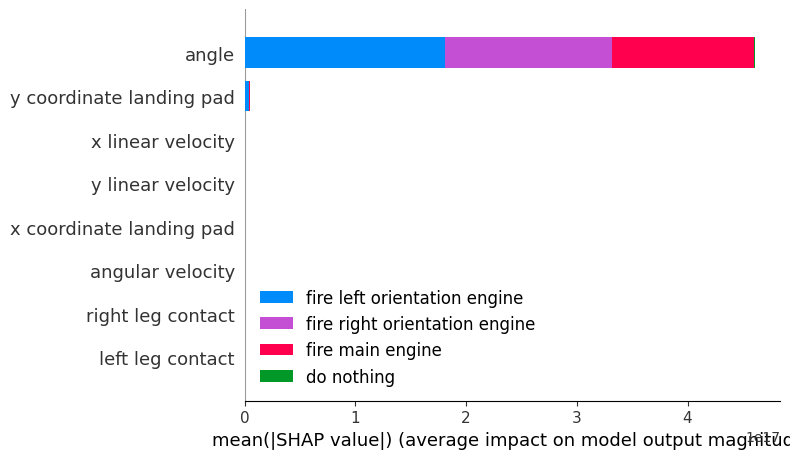

In [55]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [56]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 50,000 Capacity Size

In [57]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [58]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 50000 #memory capacity
m = 128 #memory sampling (100 samples and ~10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [59]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-1.0023578  2.4382563 -1.1805965 -0.5072068  3.1270804  1.9936306
  0.         0.       ], action: 1, score: -612.0188370466967
episode: 1, obs: [ 9.4778234e-01 -8.5630015e-02  9.7344989e-01 -1.2651427e-01
 -3.3332551e+00 -8.8103326e-07  0.0000000e+00  0.0000000e+00], action: 2, score: -721.105616857562
episode: 2, obs: [-0.28300413  0.06316653  0.7114031  -0.3931186   0.21600948 -2.562056
  0.          1.        ], action: 0, score: -36.73912821203908
episode: 3, obs: [-0.2191166  -0.03149742 -0.10633945 -0.8905118   0.02254969 -6.452836
  1.          1.        ], action: 0, score: -123.60694868631893
episode: 4, obs: [-0.47458616  0.05011104  0.43549213 -0.14510293  1.4688171   0.09550688
  0.          1.        ], action: 0, score: -142.37240855886353
episode: 5, obs: [-0.39260373 -0.06245172  0.15922426 -0.43915918  0.30267256 -4.9140325
  0.          1.        ], action: 3, score: -164.33369604609112
episode: 6, obs: [-0.46490708 -0.12846571 -0.47110915 -1.028317

#### HOW did the agent performed?

##### Agent's final score

In [60]:
#Current sum of all values in the reward window
print(agent.score())

-485116.851070176


##### Rewards at given time/step

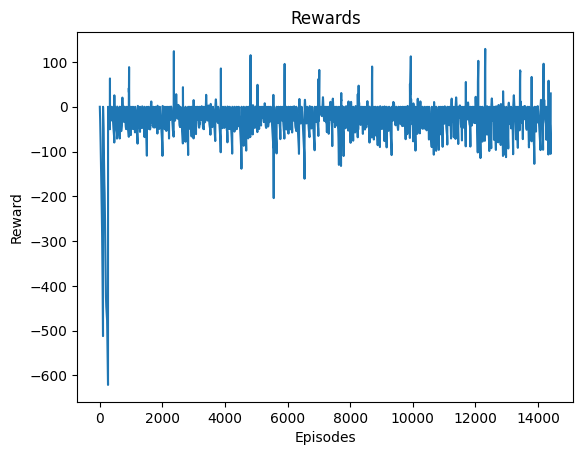

In [61]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["50k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row
# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

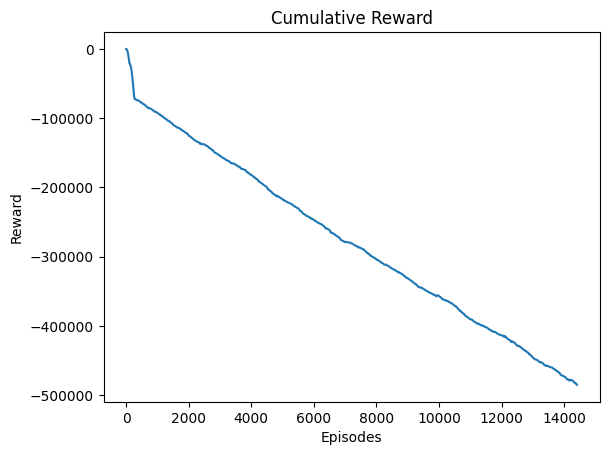

In [62]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [63]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

14280

In [64]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(0.0353), tensor(1.5791), tensor(0.207...  \
1  [[tensor(-0.3896), tensor(2.1315), tensor(-0.9...   
2  [[tensor(-0.9119), tensor(2.5018), tensor(-1.2...   
3  [[tensor(-0.0225), tensor(1.4280), tensor(-0.5...   
4  [[tensor(-0.4201), tensor(2.1913), tensor(-1.0...   

                                    batch_next_state   
0  [[tensor(0.0374), tensor(1.5922), tensor(0.209...  \
1  [[tensor(-0.3994), tensor(2.1508), tensor(-0.9...   
2  [[tensor(-0.9249), tensor(2.4949), tensor(-1.2...   
3  [[tensor(-0.0282), tensor(1.4328), tensor(-0.5...   
4  [[tensor(-0.4306), tensor(2.2110), tensor(-1.0...   

                                        batch_action   
0  [tensor(-42.3554), tensor(-75.3852), tensor(-1...  \
1  [tensor(-192.2380), tensor(-369.1706), tensor(...   
2  [tensor(-455.5289), tensor(-71.8754), tensor(-...   
3  [tensor(-6.6520), tensor(-170.5451), tensor(-5...   
4  [tensor(-209.3714), tensor(-288.3272), tensor(...   

                                        batch_reward  
0  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
1  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
2  [tensor(1), tensor(2), tensor(2), tensor(2), t...  
3  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
4  [tensor(1), tensor(1), tensor(2), tensor(1), t...

In [65]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[ 0.0353,  1.5791,  0.2072,  0.5604, -0.0666, -0.1172,  0.0000,  0.0000],
               [-0.1533,  1.6282, -0.7014,  0.5947,  0.1324,  0.0940,  0.0000,  0.0000],
               [-0.2225,  1.7659, -0.8213,  0.7258,  0.1640,  0.0575,  0.0000,  0.0000],
               [-0.1830,  1.6868, -0.7720,  0.6792,  0.1475,  0.0644,  0.0000,  0.0000],
               [-0.8604,  2.5223, -1.2410, -0.1981,  2.1008,  1.7180,  0.0000,  0.0000],
               [-0.1394,  1.6019, -0.7005,  0.5612,  0.1235,  0.0790,  0.0000,  0.0000],
               [-0.7090,  2.5146, -1.2593,  0.1839,  1.2192,  1.2477,  0.0000,  0.0000],
               [-0.1059,  1.5412, -0.6392,  0.5014,  0.1005,  0.1075,  0.0000,  0.0000],
               [-0.3608,  2.0706, -0.9495,  0.8892,  0.2587,  0.1502,  0.0000,  0.0000],
               [-0.2976,  1.9304, -0.8657,  0.8618,  0.2075,  0.1134,  0.0000,  0.0000],
               [-0.0111,  1.4189, -0.5632,  0.1830,  0.0124,  0.1206,  0.0000,  0.0000],
               [ 0.00

In [66]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [67]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[ 0.0353,  1.5791,  0.2072,  ..., -0.1172,  0.0000,  0.0000],
        [-0.1533,  1.6282, -0.7014,  ...,  0.0940,  0.0000,  0.0000],
        [-0.2225,  1.7659, -0.8213,  ...,  0.0575,  0.0000,  0.0000],
        ...,
        [ 0.3437,  1.1685,  0.7899,  ..., -0.1763,  0.0000,  0.0000],
        [ 0.6856,  1.7506,  0.8113,  ..., -0.2079,  0.0000,  0.0000],
        [-0.0122,  1.3728, -0.4102,  ...,  0.0919,  0.0000,  0.0000]])


185640

In [68]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-4.1196e-02,  1.3583e+00, -5.2091e-01, -3.8567e-01,  4.6800e-02,
          1.1660e-01,  0.0000e+00,  0.0000e+00],
        [ 6.0339e-01,  2.0036e+00,  8.1135e-01, -9.7866e-01, -2.9787e+00,
         -2.0792e-01,  0.0000e+00,  0.0000e+00],
        [-5.5352e-01,  2.3968e+00, -1.1814e+00,  5.9417e-01,  5.9357e-01,
          6.7644e-01,  0.0000e+00,  0.0000e+00],
        [ 3.5716e-01,  2.4109e+00,  6.7704e-01, -2.0296e-01, -2.4167e+00,
         -8.7128e-01,  0.0000e+00,  0.0000e+00],
        [ 1.3401e-01,  2.1783e+00,  5.0415e-01,  8.0631e-01, -4.0304e-01,
         -5.4982e-01,  0.0000e+00,  0.0000e+00],
        [ 5.7052e-01,  2.0880e+00,  8.1136e-01, -8.7203e-01, -2.9372e+00,
         -2.0793e-01,  0.0000e+00,  0.0000e+00],
        [ 1.7479e-01,  2.3019e+00,  5.6966e-01,  5.6861e-01, -6.9249e-01,
         -8.6932e-01,  0.0000e+00,  0.0000e+00],
        [ 3.6434e-01,  2.4063e+00,  6.8622e-01, -2.2421e-01, -2.4575e+00,
         -8.1660e-01,  0.0000e+00,  0.0000e+00],
        [ 8.3773

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [69]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [70]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [71]:
shap_values

[array([[-1.59220416e+18,  1.01698446e+01,  1.28287020e+01,
         -6.89282761e+01,  4.29942513e+01,  7.74035978e+00,
         -1.43201576e-10, -2.41414305e-10],
        [-1.59220416e+18, -2.56019011e-02,  2.60543594e+01,
         -1.23212791e+02, -4.67139359e+01,  1.15687752e+01,
         -1.43201576e-10, -2.41414305e-10],
        [-1.59220416e+18, -6.23641491e+00,  6.27224922e+00,
          2.07716999e+01,  5.92060738e+01,  1.13590717e+00,
         -1.43201576e-10, -2.41414305e-10],
        [-1.59220416e+18, -6.45948076e+00,  2.47210197e+01,
         -5.22018700e+01, -3.00480003e+01,  1.93945236e+01,
         -1.43201576e-10, -2.41414305e-10],
        [-1.59220416e+18, -2.78504825e+00,  2.30046978e+01,
          4.01917725e+01,  2.96563263e+01,  1.56021261e+01,
         -1.43201576e-10, -2.41414305e-10],
        [-1.59220416e+18, -1.35843062e+00,  2.60544529e+01,
         -1.13451271e+02, -4.54809608e+01,  1.15688429e+01,
         -1.43201576e-10, -2.41414305e-10],
        [-1.5922

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

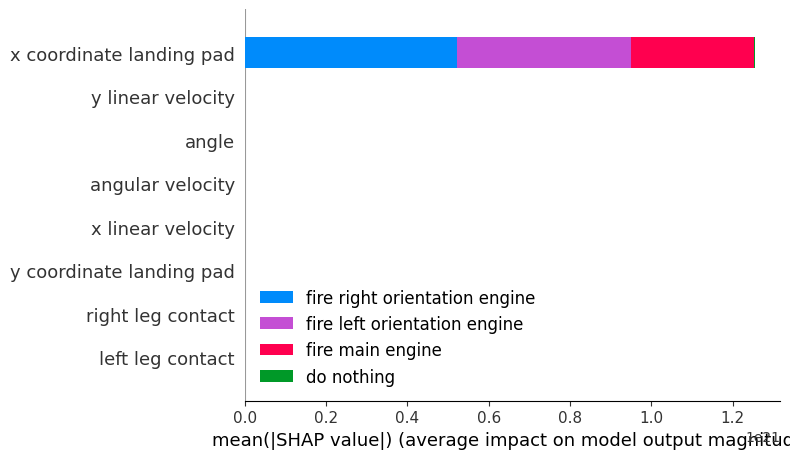

In [72]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [73]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 10,000 Capacity Size

In [74]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [75]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 10000 #memory capacity
m = 128 #memory sampling (100 samples and ~10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [76]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [ 3.0313969e-01  4.3680463e-02  4.0313593e-01  8.2299300e-02
 -2.8423376e+00  2.5310672e-07  0.0000000e+00  0.0000000e+00], action: 2, score: -536.0583802665176
episode: 1, obs: [ 1.0027479   0.63209766  2.905715   -2.050596   -3.130395   -0.96949637
  0.          0.        ], action: 2, score: -708.8770569443906
episode: 2, obs: [ 0.42023677  0.11462846 -0.2684663  -0.13068855 -1.8208995   1.5215529
  0.          0.        ], action: 0, score: -299.7441334804638
episode: 3, obs: [ 1.4063616e-01 -4.2781297e-02  1.3497501e-08  2.1559421e-08
  1.8819475e-04 -6.1075397e-08  1.0000000e+00  1.0000000e+00], action: 0, score: -133.39290044114094
episode: 4, obs: [ 0.4805192   0.07984865  0.5200132  -0.43131855 -0.46835458  4.5735908
  1.          0.        ], action: 0, score: -163.31405590229417
episode: 5, obs: [ 0.336376    0.0380313  -0.08287431 -0.4158825  -0.17989609  4.9446487
  0.          0.        ], action: 0, score: -113.57637024084508
episode: 6, obs: [-1.0728464

#### HOW did the agent performed?

##### Agent's final score

In [77]:
#Current sum of all values in the reward window
print(agent.score())

-903850.4148188045


##### Rewards at given time/step

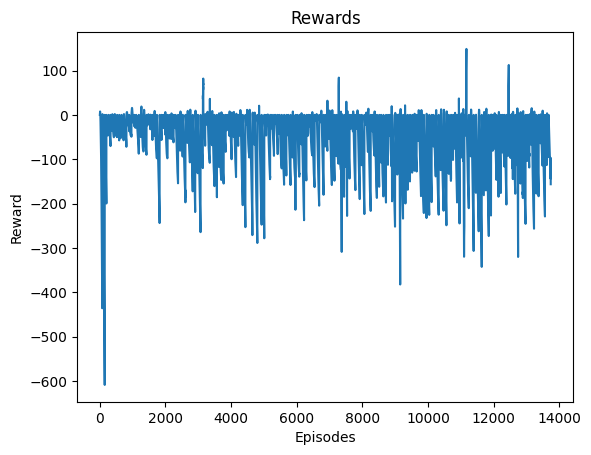

In [78]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["10k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

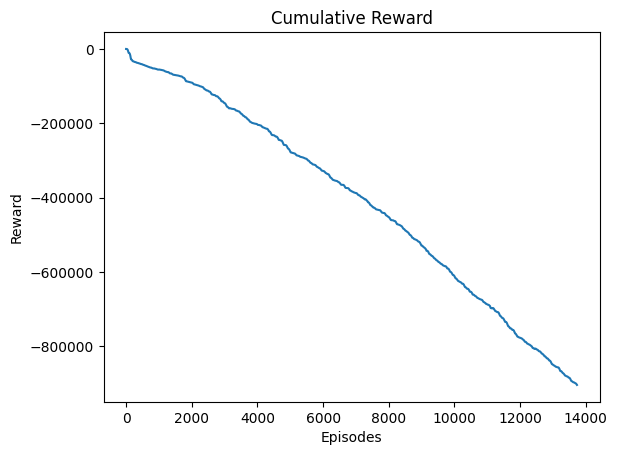

In [79]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [80]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

13607

In [81]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(0.3417), tensor(1.3113), tensor(1.920...  \
1  [[tensor(0.0409), tensor(1.4709), tensor(0.330...   
2  [[tensor(-0.1417), tensor(1.0679), tensor(0.28...   
3  [[tensor(-0.0843), tensor(1.3946), tensor(-0.4...   
4  [[tensor(0.1344), tensor(1.4059), tensor(0.942...   

                                    batch_next_state   
0  [[tensor(0.3619), tensor(1.2995), tensor(2.004...  \
1  [[tensor(0.0440), tensor(1.4684), tensor(0.341...   
2  [[tensor(-0.1381), tensor(1.0514), tensor(0.37...   
3  [[tensor(-0.0886), tensor(1.3882), tensor(-0.4...   
4  [[tensor(0.1439), tensor(1.4023), tensor(0.973...   

                                        batch_action   
0  [tensor(-346.4020), tensor(-159.7579), tensor(...  \
1  [tensor(-33.2021), tensor(-11.4910), tensor(-4...   
2  [tensor(-119.1998), tensor(-10.5374), tensor(-...   
3  [tensor(-1.7805), tensor(-338.1616), tensor(-3...   
4  [tensor(-170.2359), tensor(-338.1616), tensor(...   

                                        batch_reward  
0  [tensor(2), tensor(2), tensor(3), tensor(2), t...  
1  [tensor(3), tensor(3), tensor(3), tensor(3), t...  
2  [tensor(2), tensor(3), tensor(3), tensor(3), t...  
3  [tensor(3), tensor(2), tensor(3), tensor(2), t...  
4  [tensor(2), tensor(2), tensor(2), tensor(3), t...

In [82]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[ 0.3417,  1.3113,  1.9203, -0.5078, -1.8653, -1.0145,  0.0000,  0.0000],
               [-0.1175,  0.9809,  0.5890, -0.8497, -1.5243, -0.9986,  0.0000,  0.0000],
               [ 0.0536,  1.4571,  0.3699, -0.2089, -0.5100, -0.9011,  0.0000,  0.0000],
               [ 0.0938,  1.4241,  0.7066, -0.1713, -0.8831, -0.9367,  0.0000,  0.0000],
               [-0.0799,  1.4004, -0.4253, -0.2312, -0.1109, -0.4072,  0.0000,  0.0000],
               [ 0.2136,  0.2661,  1.8491, -1.9867, -2.7421, -0.9763,  0.0000,  0.0000],
               [ 0.0243,  1.4728,  0.2700,  0.0789, -0.1544, -0.4747,  0.0000,  0.0000],
               [ 0.1946,  0.3105,  1.8399, -1.9241, -2.6933, -0.9911,  0.0000,  0.0000],
               [-0.0709,  1.4101, -0.4431, -0.1766, -0.0721, -0.3360,  0.0000,  0.0000],
               [-0.0663,  1.4141, -0.4533, -0.1495, -0.0553, -0.2950,  0.0000,  0.0000],
               [-0.0697,  0.8579,  0.9862, -1.0253, -1.8261, -1.0142,  0.0000,  0.0000],
               [ 0.02

In [83]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [84]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[ 0.3417,  1.3113,  1.9203,  ..., -1.0145,  0.0000,  0.0000],
        [-0.1175,  0.9809,  0.5890,  ..., -0.9986,  0.0000,  0.0000],
        [ 0.0536,  1.4571,  0.3699,  ..., -0.9011,  0.0000,  0.0000],
        ...,
        [ 0.1116,  0.9372,  0.2343,  ..., -0.4701,  0.0000,  0.0000],
        [-0.1082,  0.0769, -0.0982,  ..., -0.7511,  0.0000,  0.0000],
        [ 0.2489,  1.0405,  0.7043,  ..., -0.4976,  0.0000,  0.0000]])


176891

In [85]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[ 3.0261e-01,  6.1715e-01,  8.5576e-01, -1.4418e+00, -1.2714e+00,
         -8.1842e-01,  0.0000e+00,  0.0000e+00],
        [ 7.9698e-01,  9.1633e-01,  2.8755e+00, -1.5613e+00, -2.7861e+00,
         -1.0170e+00,  0.0000e+00,  0.0000e+00],
        [-7.0912e-02,  1.4101e+00, -4.4306e-01, -1.7665e-01, -7.2114e-02,
         -3.3603e-01,  0.0000e+00,  0.0000e+00],
        [ 1.3823e-01, -1.3841e-02,  1.8877e-01, -1.8259e+00, -1.1848e-01,
          6.7817e-02,  1.0000e+00,  0.0000e+00],
        [ 1.3635e-01,  1.1423e+00,  8.5893e-01, -9.0555e-01, -4.5198e-01,
         -8.2129e-01,  0.0000e+00,  0.0000e+00],
        [ 1.3630e-01,  2.7247e-02,  1.8877e-01, -1.7992e+00, -1.2187e-01,
          6.7817e-02,  0.0000e+00,  0.0000e+00],
        [ 1.6405e-01,  1.3943e+00,  1.0414e+00, -2.1800e-01, -1.2645e+00,
         -9.8040e-01,  0.0000e+00,  0.0000e+00],
        [-2.6865e-02,  1.4241e+00, -5.2031e-01,  6.3906e-02,  1.2964e-02,
         -2.7284e-02,  0.0000e+00,  0.0000e+00],
        [-1.3751

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [86]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [87]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [88]:
shap_values

[array([[-5.89024080e+19,  1.73038578e+01,  2.87130548e+20,
         -3.34023705e+01, -2.26238046e+20, -3.77551341e+00,
         -3.73435000e-06,  1.63144949e-11],
        [-5.89024080e+19,  7.19705153e+00,  2.87130548e+20,
         -3.82376976e+01, -2.26238046e+20, -1.13045378e+01,
         -3.73435000e-06,  1.63144949e-11],
        [-5.89024080e+19, -9.48367310e+00,  2.87130548e+20,
          1.77755070e+01, -2.26238046e+20,  1.45184679e+01,
         -3.73435000e-06,  1.63144949e-11],
        [-5.89024080e+19,  3.86198044e+01,  2.87130548e+20,
         -4.89419289e+01, -2.26238046e+20,  2.98333817e+01,
         -7.93607426e+00,  1.63144949e-11],
        [-5.89024080e+19, -4.36483294e-01,  2.87130548e+20,
         -1.17109127e+01, -2.26238046e+20, -3.88409042e+00,
         -3.73435000e-06,  1.63144949e-11],
        [-5.89024080e+19,  3.72317123e+01,  2.87130548e+20,
         -4.78631325e+01, -2.26238046e+20,  2.98333569e+01,
         -3.73435000e-06,  1.63144949e-11],
        [-5.8902

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

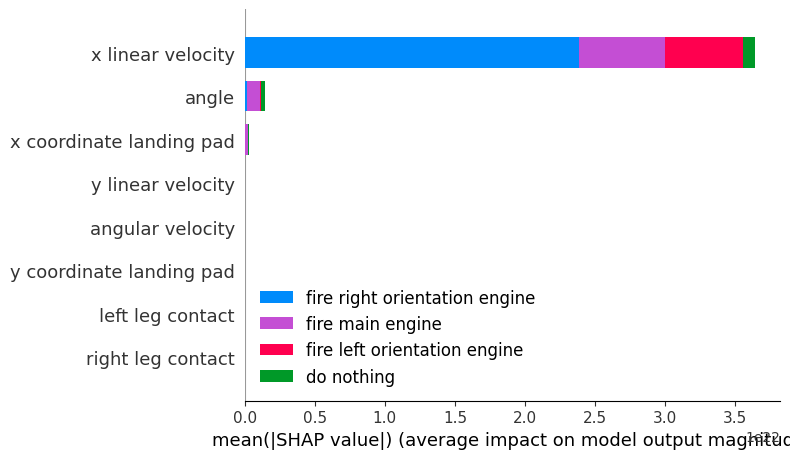

In [89]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [90]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 5,000 Capacity Size

In [91]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [92]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 5000 #memory capacity
m = 128 #memory sampling (100 samples and ~10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [93]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-0.38772264  0.06298471  0.03440134 -0.04738589 -0.16082078 -1.506364
  1.          0.        ], action: 0, score: -134.09006120932483
episode: 1, obs: [-4.4675821e-01 -1.1806274e-03 -1.3469321e-01 -9.8505753e-01
 -3.8928801e-01  6.0890508e+00  1.0000000e+00  1.0000000e+00], action: 0, score: -166.80248389216166
episode: 2, obs: [ 3.70311725e-04  1.07460115e-02  3.28573525e-01 -3.31814677e-01
 -2.82916570e+00 -4.89299679e+00  0.00000000e+00  0.00000000e+00], action: 1, score: -379.1009084505155
episode: 3, obs: [ 1.0087713 18.621532   1.0976304 -1.048589  -2.5475736  0.6074385
  0.         0.       ], action: 0, score: -2277.875553566687
episode: 4, obs: [ 1.0080656   0.5045595   2.2782578  -0.62050736 -0.7837705  -0.08581612
  0.          0.        ], action: 0, score: -372.9710888548738
episode: 5, obs: [-1.0101844e+00  9.5292456e-02 -1.8952076e+00 -2.2985561e-01
  1.8043303e-01 -4.3059050e-08  1.0000000e+00  0.0000000e+00], action: 0, score: -199.29251124143073
epi

#### HOW did the agent performed?

##### Agent's final score

In [94]:
#Current sum of all values in the reward window
print(agent.score())

-904379.0405316519


##### Rewards at given time/step

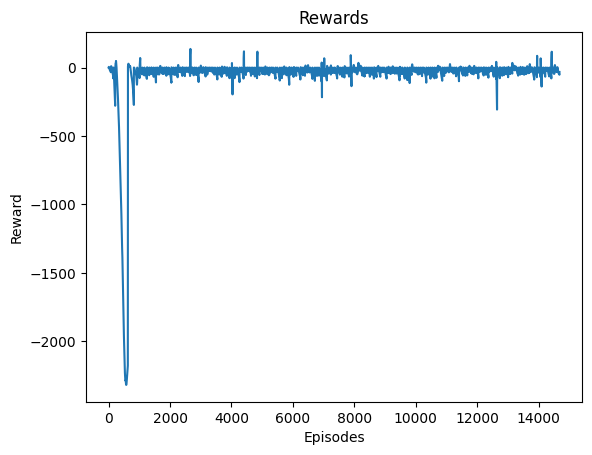

In [95]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["5k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

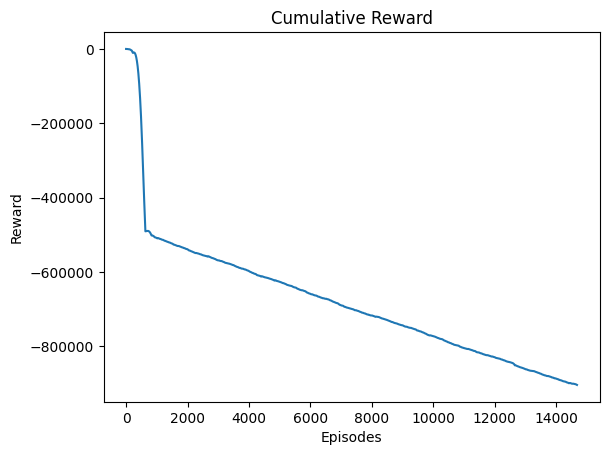

In [96]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [97]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

14553

In [98]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.2656), tensor(1.0899), tensor(-0.5...  \
1  [[tensor(-0.0110), tensor(1.4180), tensor(-0.5...   
2  [[tensor(-0.0895), tensor(1.3947), tensor(-0.5...   
3  [[tensor(-0.3038), tensor(0.9276), tensor(-0.5...   
4  [[tensor(-0.2871), tensor(0.7308), tensor(-0.5...   

                                    batch_next_state   
0  [[tensor(-0.2711), tensor(1.0685), tensor(-0.5...  \
1  [[tensor(-0.0163), tensor(1.4206), tensor(-0.5...   
2  [[tensor(-0.0947), tensor(1.3883), tensor(-0.5...   
3  [[tensor(-0.3092), tensor(0.9020), tensor(-0.5...   
4  [[tensor(-0.2923), tensor(0.7016), tensor(-0.5...   

                                        batch_action   
0  [tensor(-33.3836), tensor(-15.5023), tensor(-7...  \
1  [tensor(0.8662), tensor(-10.9348), tensor(5.40...   
2  [tensor(2.4915), tensor(0.8569), tensor(-22.15...   
3  [tensor(-40.5682), tensor(-4.2820), tensor(-22...   
4  [tensor(-22.1529), tensor(-12.5674), tensor(7....   

                                        batch_reward  
0  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
1  [tensor(3), tensor(0), tensor(3), tensor(0), t...  
2  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
3  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
4  [tensor(0), tensor(0), tensor(0), tensor(0), t...

In [99]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[-0.2656,  1.0899, -0.5374, -0.9251, -0.2588, -0.1502,  0.0000,  0.0000],
               [-0.1987,  1.1350, -0.5185, -0.8167, -0.0397, -0.0343,  0.0000,  0.0000],
               [-0.1467,  1.2917, -0.5185, -0.5500, -0.0226, -0.0343,  0.0000,  0.0000],
               [-0.2003,  1.2997, -0.5374, -0.6050, -0.1687, -0.1502,  0.0000,  0.0000],
               [-0.2220,  1.2394, -0.5374, -0.7117, -0.1987, -0.1502,  0.0000,  0.0000],
               [-0.3756,  0.1533, -0.5185, -1.7234, -0.0980, -0.0343,  0.0000,  0.0000],
               [-0.1311,  1.3271, -0.5185, -0.4691, -0.0175, -0.0343,  0.0000,  0.0000],
               [-0.2820,  1.0239, -0.5374, -1.0051, -0.2813, -0.1502,  0.0000,  0.0000],
               [-0.2403,  0.9664, -0.5185, -1.0300, -0.0535, -0.0343,  0.0000,  0.0000],
               [-0.0578,  1.4581, -0.5480,  0.0892,  0.0076, -0.1089,  0.0000,  0.0000],
               [-0.2247,  1.0341, -0.5185, -0.9500, -0.0483, -0.0343,  0.0000,  0.0000],
               [-0.24

In [100]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [101]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.2656,  1.0899, -0.5374,  ..., -0.1502,  0.0000,  0.0000],
        [-0.1987,  1.1350, -0.5185,  ..., -0.0343,  0.0000,  0.0000],
        [-0.1467,  1.2917, -0.5185,  ..., -0.0343,  0.0000,  0.0000],
        ...,
        [-0.2358,  0.2125, -0.3312,  ...,  0.0739,  0.0000,  0.0000],
        [-0.4263, -0.0770,  0.4810,  ..., -1.3588,  0.0000,  1.0000],
        [-0.2340,  0.0632, -0.3756,  ...,  0.0838,  0.0000,  1.0000]])


189189

In [102]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-4.2177e-01,  2.2500e-01, -4.8806e-01, -1.7155e+00, -5.3005e-01,
         -3.8385e-01,  0.0000e+00,  0.0000e+00],
        [-6.0226e-03,  1.4183e+00, -6.1005e-01,  3.2945e-01,  6.9855e-03,
          1.3818e-01,  0.0000e+00,  0.0000e+00],
        [-1.1546e-01,  1.3569e+00, -5.1848e-01, -3.8908e-01, -1.2316e-02,
         -3.4301e-02,  0.0000e+00,  0.0000e+00],
        [-2.3589e-02,  1.2719e+00, -7.4024e-02, -6.0300e-01, -1.8721e-01,
         -5.3315e-01,  0.0000e+00,  0.0000e+00],
        [-6.8044e-03,  1.4047e+00, -2.7906e-02,  5.5777e-01,  9.1309e-03,
          3.0590e-03,  0.0000e+00,  0.0000e+00],
        [-2.0910e-01,  1.0964e+00, -5.1848e-01, -8.7004e-01, -4.3169e-02,
         -3.4279e-02,  0.0000e+00,  0.0000e+00],
        [-1.8829e-01,  1.1711e+00, -5.1848e-01, -7.6338e-01, -3.6313e-02,
         -3.4279e-02,  0.0000e+00,  0.0000e+00],
        [-3.8077e-01,  1.1389e-01, -5.1848e-01, -1.7501e+00, -9.9729e-02,
         -3.4279e-02,  0.0000e+00,  0.0000e+00],
        [-6.8642

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [103]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [104]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [105]:
shap_values

[array([[-7.80129433e+00,  3.74367309e+00,  8.48804101e+24,
         -2.85814026e+02, -1.64367893e+20, -1.82293582e+00,
          2.09998978e+22, -7.77597506e-06],
        [ 5.25455427e+00, -2.09879436e+01,  8.48804101e+24,
          2.42395630e+02, -1.64367893e+20,  2.38124776e+00,
          2.09998978e+22, -7.77597506e-06],
        [ 1.81774890e+00, -1.97153282e+01,  8.48804101e+24,
          5.67966881e+01, -1.64367893e+20,  9.92144406e-01,
          2.09998978e+22, -7.77597506e-06],
        [ 4.70288849e+00, -1.79529095e+01,  8.48804101e+24,
          1.53983974e+00, -1.64367893e+20, -3.02527237e+00,
          2.09998978e+22, -7.77597506e-06],
        [ 5.22999001e+00, -2.07061176e+01,  8.48804101e+24,
          3.01372437e+02, -1.64367893e+20,  1.29302061e+00,
          2.09998978e+22, -7.77597506e-06],
        [-1.12277687e+00, -1.43167486e+01,  8.48804101e+24,
         -6.74394150e+01, -1.64367893e+20,  9.92321551e-01,
          2.09998978e+22, -7.77597506e-06],
        [-4.6932

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

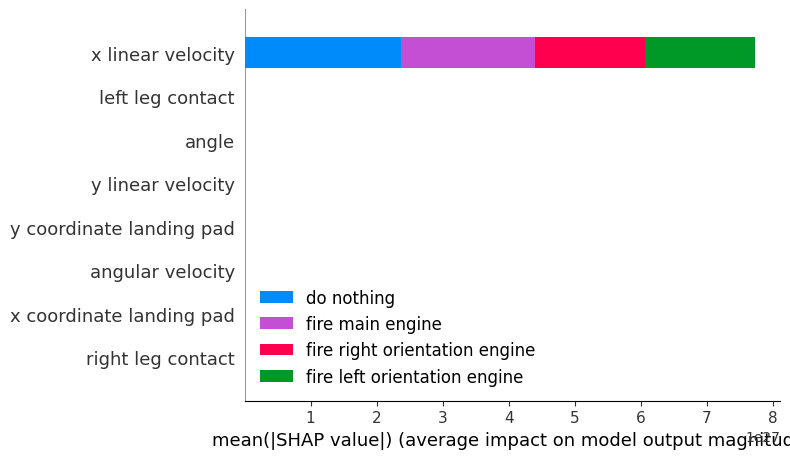

In [106]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [107]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 1,000 Capacity Size

In [108]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [109]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 1000 #memory capacity
m = 128 #memory sampling (100 samples and ~10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [110]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-0.24185419  0.02836841  0.13826653 -0.09608153 -4.7490773  -0.60005534
  0.          1.        ], action: 3, score: -591.697334606074
episode: 1, obs: [ 0.3160387   0.05343233 -0.22192502 -0.6979952  -2.912738    5.25207
  0.          0.        ], action: 3, score: -447.6924434544114
episode: 2, obs: [-0.11181116 -0.00749047 -0.17466411 -0.33724257 -0.51217556  4.0542417
  1.          0.        ], action: 3, score: -160.4382503962389
episode: 3, obs: [-0.2126172   0.01543559  1.0070729   0.11782432 -2.3276122  -2.7807784
  0.          0.        ], action: 2, score: -261.492119125753
episode: 4, obs: [ 1.0368164   0.05427977  3.969345   -1.6473138  -2.1440787  -0.41661054
  0.          0.        ], action: 2, score: -644.9479617951063
episode: 5, obs: [ 1.002628    4.059529    1.168566    0.30784684 -0.8002239  -0.25751776
  0.          0.        ], action: 3, score: -536.1444002026503
episode: 6, obs: [-0.2581429   0.03422264  0.22896251  0.00776893 -2.2748249  -0.63

#### HOW did the agent performed?

##### Agent's final score

In [111]:
#Current sum of all values in the reward window
print(agent.score())

-1052837.0639542935


##### Rewards at given time/step

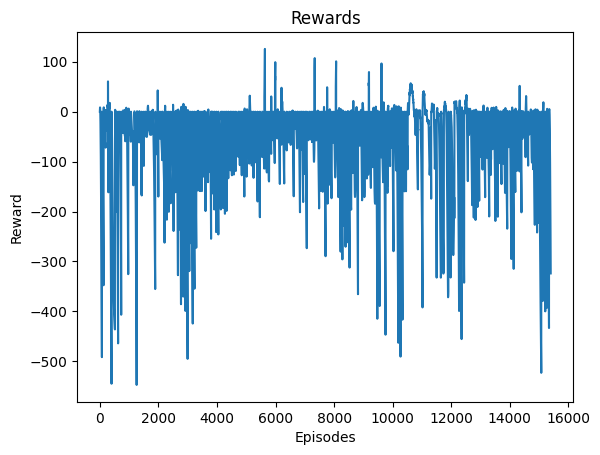

In [112]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["1k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

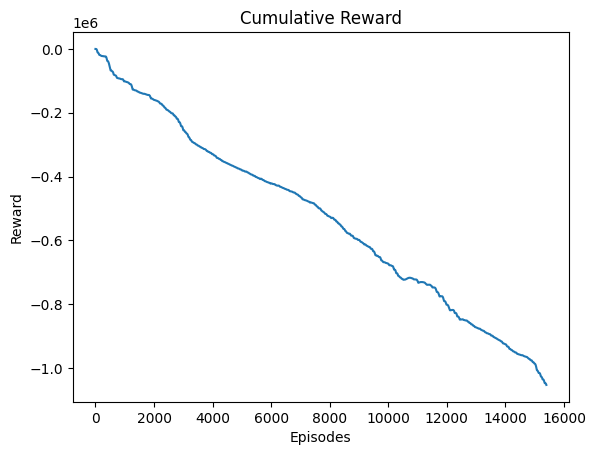

In [113]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [114]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

15270

In [115]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(0.2021), tensor(0.7068), tensor(0.653...  \
1  [[tensor(0.2216), tensor(0.6119), tensor(0.650...   
2  [[tensor(-0.1772), tensor(0.9241), tensor(-0.2...   
3  [[tensor(0.2755), tensor(0.3266), tensor(0.614...   
4  [[tensor(0.0465), tensor(1.3080), tensor(0.479...   

                                    batch_next_state   
0  [[tensor(0.2086), tensor(0.6759), tensor(0.653...  \
1  [[tensor(0.2282), tensor(0.5788), tensor(0.649...   
2  [[tensor(-0.1792), tensor(0.8978), tensor(-0.2...   
3  [[tensor(0.2824), tensor(0.2876), tensor(0.607...   
4  [[tensor(0.0512), tensor(1.2950), tensor(0.490...   

                                        batch_action   
0  [tensor(-182.8598), tensor(-269.7322), tensor(...  \
1  [tensor(-206.6294), tensor(-109.3385), tensor(...   
2  [tensor(-205.6470), tensor(-405.9263), tensor(...   
3  [tensor(-279.6143), tensor(0.), tensor(-430.74...   
4  [tensor(-27.4314), tensor(-132.6341), tensor(0...   

                                        batch_reward  
0  [tensor(3), tensor(3), tensor(3), tensor(3), t...  
1  [tensor(3), tensor(1), tensor(3), tensor(3), t...  
2  [tensor(3), tensor(3), tensor(3), tensor(3), t...  
3  [tensor(3), tensor(3), tensor(3), tensor(3), t...  
4  [tensor(3), tensor(3), tensor(3), tensor(3), t...

In [116]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[ 0.2021,  0.7068,  0.6536, -1.3942, -1.4401, -1.4727,  0.0000,  0.0000],
               [ 0.2687,  0.3649,  0.6202, -1.7181, -2.3011, -1.9252,  0.0000,  0.0000],
               [ 0.0560,  1.2813,  0.5014, -0.6082, -0.1770, -0.5025,  0.0000,  0.0000],
               [ 0.1293,  1.0257,  0.6112, -1.0168, -0.7000, -1.0117,  0.0000,  0.0000],
               [-0.1772,  0.9241, -0.2368, -1.1973, -1.8868, -1.8579,  0.0000,  0.0000],
               [ 0.0608,  1.2671,  0.5093, -0.6363, -0.2038, -0.5350,  0.0000,  0.0000],
               [-0.1585,  1.1085, -0.2350, -0.9281, -1.2159, -1.4408,  0.0000,  0.0000],
               [ 0.0039,  1.4046,  0.3991, -0.2821, -0.0046, -0.0904,  0.0000,  0.0000],
               [ 0.0512,  1.2950,  0.4904, -0.5806, -0.1519, -0.4580,  0.0000,  0.0000],
               [-0.0163,  1.4206, -0.5408,  0.1177,  0.0135,  0.0547,  0.0000,  0.0000],
               [-0.2105,  0.4098, -0.3675, -1.6508, -3.6561, -2.5030,  0.0000,  0.0000],
               [ 0.00

In [117]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [118]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[ 0.2021,  0.7068,  0.6536,  ..., -1.4727,  0.0000,  0.0000],
        [ 0.2687,  0.3649,  0.6202,  ..., -1.9252,  0.0000,  0.0000],
        [ 0.0560,  1.2813,  0.5014,  ..., -0.5025,  0.0000,  0.0000],
        ...,
        [-0.1893,  0.9132, -0.2202,  ..., -0.9478,  0.0000,  0.0000],
        [ 0.0431,  0.0874,  0.1614,  ..., -0.7362,  0.0000,  0.0000],
        [ 0.0137,  1.4002,  0.0326,  ..., -0.1008,  0.0000,  0.0000]])


198510

In [119]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-1.0278e-01,  4.6457e-01, -1.3458e-01, -1.5016e+00, -3.2076e-01,
         -1.8973e-01,  0.0000e+00,  0.0000e+00],
        [-3.2065e-01,  6.2589e-01, -5.2186e-01, -1.1445e+00, -3.8971e-01,
         -2.4796e-01,  0.0000e+00,  0.0000e+00],
        [ 1.6843e+04,  1.7047e+04,  2.3859e+04,  2.3862e+04,  2.3862e+04,
          2.3863e+04,  2.3863e+04,  2.4018e+04],
        [-7.5860e-02,  9.3061e-01, -1.7267e-01, -1.0669e+00, -2.7528e-01,
         -2.6159e-02,  0.0000e+00,  0.0000e+00],
        [ 2.0210e-02,  1.3732e+00,  4.1928e-01, -3.8898e-01, -3.5189e-02,
         -1.7223e-01,  0.0000e+00,  0.0000e+00],
        [-2.1865e-01,  1.0323e+00, -6.4561e-01, -9.4106e-01, -1.9227e-01,
         -2.4681e-01,  0.0000e+00,  0.0000e+00],
        [-1.0992e-01,  2.4880e-01, -8.6683e-02, -1.6731e+00, -4.1837e-01,
         -3.9961e-01,  0.0000e+00,  0.0000e+00],
        [-2.5154e-01,  9.1766e-01, -6.4563e-01, -1.0745e+00, -2.5397e-01,
         -2.4680e-01,  0.0000e+00,  0.0000e+00],
        [-9.8243

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [120]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [121]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [122]:
shap_values

[array([[-2.86544708e+02, -4.69726562e+03, -6.24200684e+03,
          3.55865997e+02,  1.54663789e+04,  1.22436836e+04,
         -2.43978735e+03, -2.95724030e+02],
        [-2.87220734e+02, -4.66976758e+03, -6.20821777e+03,
          6.07444153e+02,  1.54522227e+04,  1.22415801e+04,
         -2.43978735e+03, -2.95724030e+02],
        [ 5.19757891e+04,  2.90114900e+06, -2.08812750e+06,
          1.68119120e+07,  4.91121850e+06,  8.77227750e+05,
          9.73106100e+06,  5.89012400e+06],
        [-2.86461060e+02, -4.61783105e+03, -6.23869238e+03,
          6.62081726e+02,  1.54757031e+04,  1.22496113e+04,
         -2.43978735e+03, -2.95724030e+02],
        [-2.86163055e+02, -4.54237549e+03, -6.29034619e+03,
          1.13970764e+03,  1.55249590e+04,  1.22443203e+04,
         -2.43978735e+03, -2.95724030e+02],
        [-2.86904022e+02, -4.60048096e+03, -6.19741211e+03,
          7.50764587e+02,  1.54927393e+04,  1.22416250e+04,
         -2.43978735e+03, -2.95724030e+02],
        [-2.8656

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

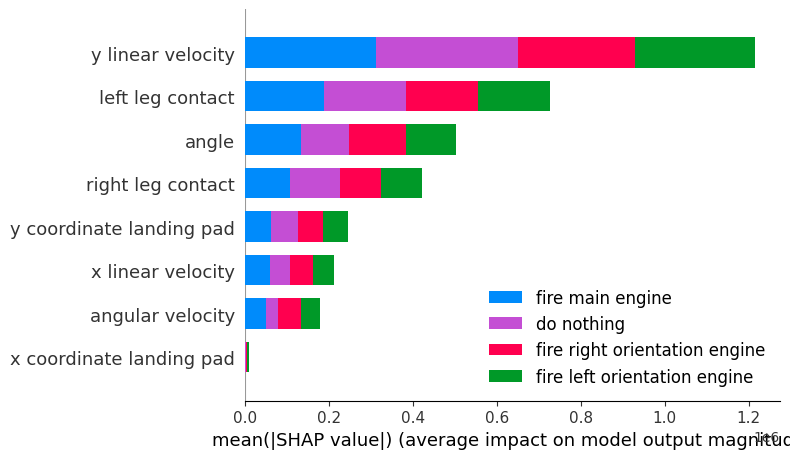

In [123]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [124]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 500 Capacity Size

In [125]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [126]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 500 #memory capacity
m = 128 #memory sampling (100 samples and ~10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [127]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-0.41966215  0.05702499 -1.2799711  -0.39496458  0.42497137 -0.2031985
  0.          1.        ], action: 0, score: -157.83663034211023
episode: 1, obs: [-0.58477443  0.14094137 -0.6460152   0.1296949   0.6398952   1.8707094
  0.          1.        ], action: 2, score: -167.98208279378818
episode: 2, obs: [ 4.7798806e-01 -1.1034210e-01  1.0132897e+00 -1.3788584e-01
 -2.0077915e-01  1.5236392e-07  1.0000000e+00  1.0000000e+00], action: 3, score: -145.30076660639358
episode: 3, obs: [ 0.6008747  -0.15240057  1.5648463  -0.08950989 -2.4817083  -4.7547317
  0.          0.        ], action: 1, score: -485.2743579185962
episode: 4, obs: [ 0.36628476 -0.11627207  0.73494565 -0.9397499  -0.6401948   5.4939203
  1.          0.        ], action: 0, score: -242.16378567914936
episode: 5, obs: [-0.463833    0.02299791 -0.19819722 -0.26626816  3.2014132  -3.3996882
  0.          0.        ], action: 0, score: -479.6394513423335
episode: 6, obs: [-5.3896237e-02 -4.2780723e-02  4.44

#### HOW did the agent performed?

##### Agent's final score

In [128]:
#Current sum of all values in the reward window
print(agent.score())

-866743.3933701747


##### Rewards at given time/step

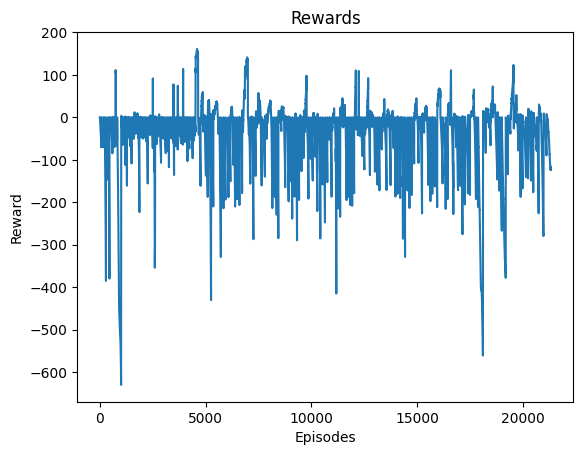

In [129]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["500", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

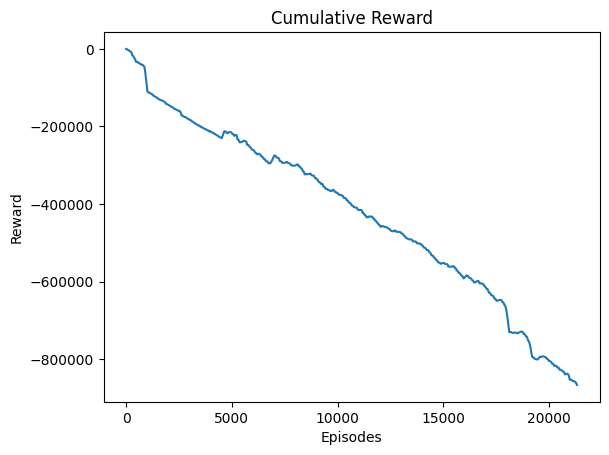

In [130]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [131]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

21189

In [132]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.1627), tensor(1.4012), tensor(-0.6...  \
1  [[tensor(-0.1928), tensor(1.3514), tensor(-0.6...   
2  [[tensor(-0.2049), tensor(1.3272), tensor(-0.6...   
3  [[tensor(-0.0542), tensor(1.4562), tensor(-0.6...   
4  [[tensor(-0.3496), tensor(0.8506), tensor(-0.6...   

                                    batch_next_state   
0  [[tensor(-0.1687), tensor(1.3925), tensor(-0.6...  \
1  [[tensor(-0.1989), tensor(1.3396), tensor(-0.6...   
2  [[tensor(-0.2109), tensor(1.3143), tensor(-0.6...   
3  [[tensor(-0.0602), tensor(1.4583), tensor(-0.6...   
4  [[tensor(-0.3556), tensor(0.8233), tensor(-0.6...   

                                        batch_action   
0  [tensor(-18.6355), tensor(-11.3071), tensor(-4...  \
1  [tensor(-25.1534), tensor(-0.2808), tensor(-9....   
2  [tensor(-27.7797), tensor(-37.5795), tensor(-1...   
3  [tensor(-2.0664), tensor(-52.9419), tensor(-3....   
4  [tensor(-53.3945), tensor(-34.1800), tensor(-6...   

                                        batch_reward  
0  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
1  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
2  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
3  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
4  [tensor(0), tensor(0), tensor(0), tensor(0), t...

In [133]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[-0.1627,  1.4012, -0.6094, -0.3640,  0.1845,  0.1360,  0.0000,  0.0000],
               [-0.0939,  1.3949, -0.5586, -0.2555,  0.1064,  0.1248,  0.0000,  0.0000],
               [-0.2375,  1.0348, -0.5585, -0.9499,  0.2684,  0.1246,  0.0000,  0.0000],
               [-0.2531,  1.2067, -0.6094, -0.7640,  0.2865,  0.1360,  0.0000,  0.0000],
               [-0.2982,  0.7604, -0.5585, -1.2433,  0.3370,  0.1246,  0.0000,  0.0000],
               [-0.1933,  1.1888, -0.5585, -0.7366,  0.2186,  0.1246,  0.0000,  0.0000],
               [-0.2652,  1.1706, -0.6094, -0.8174,  0.3001,  0.1360,  0.0000,  0.0000],
               [-0.4032,  0.1156, -0.5584, -1.7500,  0.4554,  0.1246,  0.0000,  0.0000],
               [-0.1712,  1.2514, -0.5585, -0.6299,  0.1936,  0.1246,  0.0000,  0.0000],
               [-0.0166,  1.4207, -0.5583,  0.1179,  0.0189,  0.1251,  0.0000,  0.0000],
               [-0.2591,  1.1890, -0.6094, -0.7907,  0.2933,  0.1360,  0.0000,  0.0000],
               [-0.24

In [134]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [135]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.1627,  1.4012, -0.6094,  ...,  0.1360,  0.0000,  0.0000],
        [-0.0939,  1.3949, -0.5586,  ...,  0.1248,  0.0000,  0.0000],
        [-0.2375,  1.0348, -0.5585,  ...,  0.1246,  0.0000,  0.0000],
        ...,
        [ 0.0294,  1.3144, -0.3257,  ...,  0.1506,  0.0000,  0.0000],
        [-0.7479,  0.9394, -2.0770,  ...,  0.0676,  0.0000,  0.0000],
        [ 0.3329,  0.9687,  0.6091,  ..., -0.0591,  0.0000,  0.0000]])


275457

In [136]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-0.1657,  1.2656, -0.5585, -0.6032,  0.1874,  0.1246,  0.0000,  0.0000],
        [-0.1989,  1.3396, -0.6094, -0.5240,  0.2253,  0.1360,  0.0000,  0.0000],
        [ 0.3591,  0.5093,  0.6189, -1.4342, -0.3202,  0.2152,  0.0000,  0.0000],
        [ 0.2438,  0.9814,  0.7045, -1.0003, -0.2761, -0.1572,  0.0000,  0.0000],
        [ 0.1686,  0.9462,  0.6642, -1.0695, -0.8872, -0.8987,  0.0000,  0.0000],
        [-0.3556,  0.8233, -0.6094, -1.2174,  0.4021,  0.1360,  0.0000,  0.0000],
        [-0.2817,  0.8424, -0.5585, -1.1633,  0.3183,  0.1246,  0.0000,  0.0000],
        [ 0.2135,  0.7973,  0.9246, -1.1538, -1.1668, -0.9178,  0.0000,  0.0000],
        [-0.3315,  0.9291, -0.6094, -1.1108,  0.3749,  0.1360,  0.0000,  0.0000],
        [-0.1627,  1.4012, -0.6094, -0.3640,  0.1845,  0.1360,  0.0000,  0.0000],
        [ 0.4386,  0.0730,  0.7166, -1.7719, -0.2976, -0.1976,  0.0000,  0.0000],
        [-0.1326,  1.4360, -0.6096, -0.2297,  0.1501,  0.1361,  0.0000,  0.0000],
        [-0.2712

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [137]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [138]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [139]:
shap_values

[array([[ 1.56931279e+21,  1.36436911e+01,  4.72348121e+23,
          2.75611210e+01, -8.59699057e+21,  6.24115944e+00,
         -7.24347483e-05, -2.25212169e+00],
        [ 1.56931279e+21,  1.77130280e+01,  4.72348121e+23,
          4.15995369e+01, -8.59699057e+21,  3.42950177e+00,
         -7.24347483e-05, -2.25212169e+00],
        [ 1.56931279e+21, -2.79224987e+01,  4.72348121e+23,
         -1.19695824e+02, -8.59699057e+21, -1.61646729e+01,
         -7.24347483e-05, -2.25212169e+00],
        [ 1.56931279e+21, -1.97577310e+00,  4.72348121e+23,
         -4.28058167e+01, -8.59699057e+21,  7.60278931e+01,
         -7.24347483e-05, -2.25212169e+00],
        [ 1.56931279e+21, -3.90978122e+00,  4.72348121e+23,
         -5.50762749e+01, -8.59699057e+21,  2.59591431e+02,
         -7.24347483e-05, -2.25212169e+00],
        [ 1.56931279e+21, -1.06652460e+01,  4.72348121e+23,
         -8.12880707e+01, -8.59699057e+21,  3.43220496e+00,
         -7.24347483e-05, -2.25212169e+00],
        [ 1.5693

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

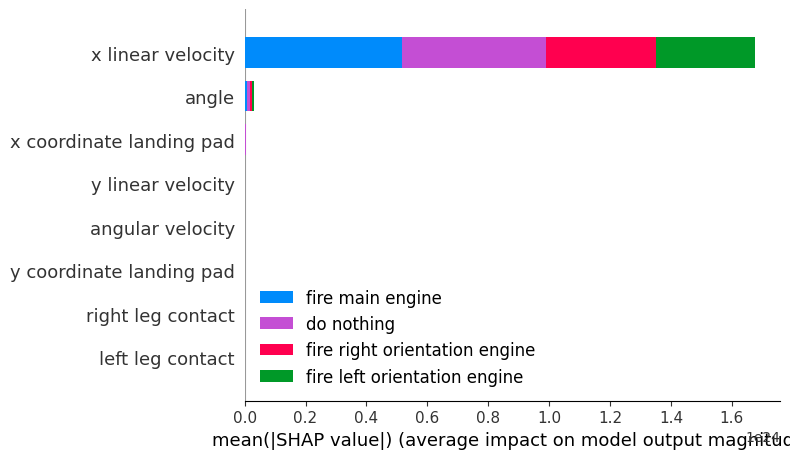

In [140]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [141]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

## ANOVA

In [142]:
df_rewards.tail()

capacity  episodes      reward
140190      500     21312 -123.774002
140191      500     21313 -122.425033
140192      500     21314 -123.230742
140193      500     21315 -122.912912
140194      500     21316 -123.792762

In [143]:
x = datetime.datetime.now()
file_name = str(x.year) + "_" + str(x.month) + "_" + str(x.day) + "_" + str(x.strftime("%H")) + "_" + str(x.strftime("%M")) + "_" + str(x.strftime("%S")) + "_lunar_lander" + ".csv"
df_rewards.to_csv(file_name, index=False, encoding='utf-8')

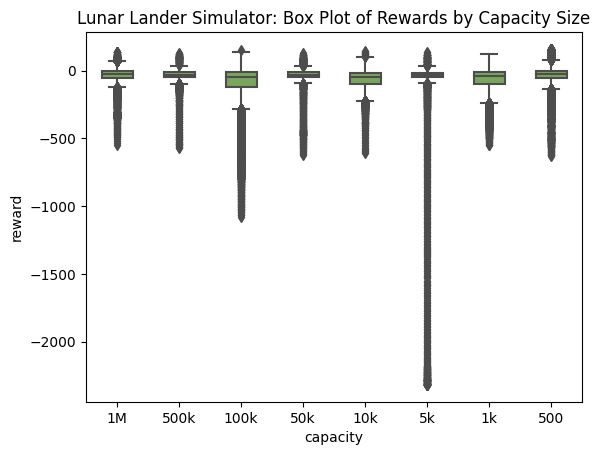

In [144]:
ax = sns.boxplot(x='capacity', y='reward', data=df_rewards, color='#77B150', width=0.5).set(title='Lunar Lander Simulator: Box Plot of Rewards by Capacity Size')
plt.show()

In [145]:
# Perform ANOVA and obtain group means
model = ols('reward ~ C(capacity)', data=df_rewards).fit()

In [146]:
group_means = df_rewards.groupby('capacity')['reward'].mean()
print(group_means)

capacity
100k   -101.986610
10k     -65.806364
1M      -29.327667
1k      -68.374923
500     -40.659727
500k    -32.008487
50k     -33.669965
5k      -61.602005
Name: reward, dtype: float64


In [147]:
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                   sum_sq        df           F  PR(>F)
C(capacity)  9.023556e+07       7.0  982.981657     0.0
Residual     1.838408e+09  140187.0         NaN     NaN


p-value (PR(>F)): 0.0 indicates that the p-value is extremely small (below the typical threshold of 0.05), suggesting strong evidence to reject the null hypothesis. This means that there is a significant difference between at least two group means of the "capacity" variable.

 "capacity" variable has a significant effect on the "reward" variable. F-statistic is large, further supporting the conclusion that the means of the different "capacity" groups are significantly different from each other.

In [148]:
# Perform Tukey's HSD test
mc_results = mc.MultiComparison(df_rewards['reward'], df_rewards['capacity'])
tukey_results = mc_results.tukeyhsd()

In [149]:
# Print the results
print(tukey_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
  100k    10k  36.1802    0.0  32.4485   39.912   True
  100k     1M  72.6589    0.0  69.4347  75.8831   True
  100k     1k  33.6117    0.0  30.0091  37.2143   True
  100k    500  61.3269    0.0  58.0396  64.6142   True
  100k   500k  69.9781    0.0   66.293  73.6633   True
  100k    50k  68.3166    0.0  64.6402  71.9931   True
  100k     5k  40.3846    0.0  36.7293  44.0399   True
   10k     1M  36.4787    0.0  32.7356  40.2218   True
   10k     1k  -2.5686 0.5432  -6.6422   1.5051  False
   10k    500  25.1466    0.0   21.349  28.9443   True
   10k   500k  33.7979    0.0  29.6511  37.9447   True
   10k    50k  32.1364    0.0  27.9973  36.2755   True
   10k     5k   4.2044 0.0416   0.0841   8.3246   True
    1M     1k -39.0473    0.0 -42.6617 -35.4329   True
    1M    500 -11.3321    0.0 -14.6323  -8.0318   True
    1M   5